In [1]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


In [2]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    train_and_evaluate_models,
    convert_results_to_dataframe,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots,
    grid_search_best_params
)

In [3]:
merged_df_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(merged_df_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

#np.random.seed(123)
#merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

# Train / Test

In [4]:
train_test_split_original_data_path = "../data/03_processed/train_test_split_original_data.csv"
train_test_split_original_data = pd.read_csv(train_test_split_original_data_path)

train_test_split_new_data_path = "../data/03_processed/train_test_split_new_data.csv"
train_test_split_new_data = pd.read_csv(train_test_split_new_data_path)

train_test_split = pd.concat([train_test_split_original_data, train_test_split_new_data], ignore_index=True)

merged_df = merged_df.merge(train_test_split, on=['index', 'geonameid'], how='left')

# We want to keep original data 
merged_df = merged_df[merged_df["source"] == "World Bank CURB"]

In [5]:
features = [
    "hdd_total_year", 
    #"cdd_total_year", 
    #"GDP_per_capita", 
    #"Urbanization_Rate_2022",
    #"latitude",
    #"longitude",  
    #"Paris_Agreement",
    "Subnational HDI", 
    #"Educational index", 
    "Income index",
    "2m_temperature_2023_avg",
    "2m_dewpoint_temperature_2023_avg",
    #"total_precipitation_2023",
    #"longitude_sin", 
    "longitude_cos", 
    "latitude_sin", 
    "latitude_cos",  
    #"population_density"
]

feature_abbreviations = {
    "hdd_total_year": "HDD",
    "cdd_total_year": "CDD", 
    "GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
   # "latitude": "Lat",
   # "longitude": "Long",
    "Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU" , 
    "Income index": "Income",
    "2m_temperature_2023_avg": "Temp",
    "2m_dewpoint_temperature_2023_avg": "Dew",
    "total_precipitation_2023": "Precip",
    "longitude_sin": "Long_Sin", 
    "longitude_cos": "Long_Cos", 
    "latitude_sin": "Lat_Sin", 
    "latitude_cos": "Lat_Cos",  
    "population_density": "Pop_Dens"
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# Random Forest - Grid Serach

In [6]:
# Define parameter grid for RandomForestRegressor

rf_param_grid = {
    'n_estimators': [10, 30, 50, 100, 200],
    #'max_depth': [None, 5, 10, 15, 20],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 3, 5],
    #'max_features': ['sqrt', 'log2', 0.5, 0.7],
    #'bootstrap': [True, False],
    #'random_state': [42],
    #'n_jobs': [-1],
    #'criterion': ['squared_error', 'absolute_error', 'poisson']
}

# Run grid search with cross-validation
best_params, best_score, all_results = grid_search_best_params(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_class=RandomForestRegressor,
    param_grid=rf_param_grid,
    feature_abbreviations=feature_abbreviations
)

rf_params = best_params

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
rf_grid_search_results = convert_results_to_dataframe(all_results, features)
rf_grid_search_results.to_csv(f'../results/gridsearch/{timestamp}_rf_grid_search_results.csv')

Evaluating combination 1/5: {'n_estimators': 10}
Strategy 'within_domain' - Overall Average MAPE: 12.33%
Strategy 'cross_domain' - Overall Average MAPE: 18.80%
Strategy 'all_domain' - Overall Average MAPE: 14.49%
Evaluating combination 2/5: {'n_estimators': 30}
Strategy 'within_domain' - Overall Average MAPE: 12.18%
Strategy 'cross_domain' - Overall Average MAPE: 18.25%
Strategy 'all_domain' - Overall Average MAPE: 13.37%
Evaluating combination 3/5: {'n_estimators': 50}
Strategy 'within_domain' - Overall Average MAPE: 12.21%
Strategy 'cross_domain' - Overall Average MAPE: 18.27%
Strategy 'all_domain' - Overall Average MAPE: 13.18%
Evaluating combination 4/5: {'n_estimators': 100}
Strategy 'within_domain' - Overall Average MAPE: 12.28%
Strategy 'cross_domain' - Overall Average MAPE: 18.01%
Strategy 'all_domain' - Overall Average MAPE: 13.17%
Evaluating combination 5/5: {'n_estimators': 200}
Strategy 'within_domain' - Overall Average MAPE: 12.24%
Strategy 'cross_domain' - Overall Average

### Random Forest - Within Domain

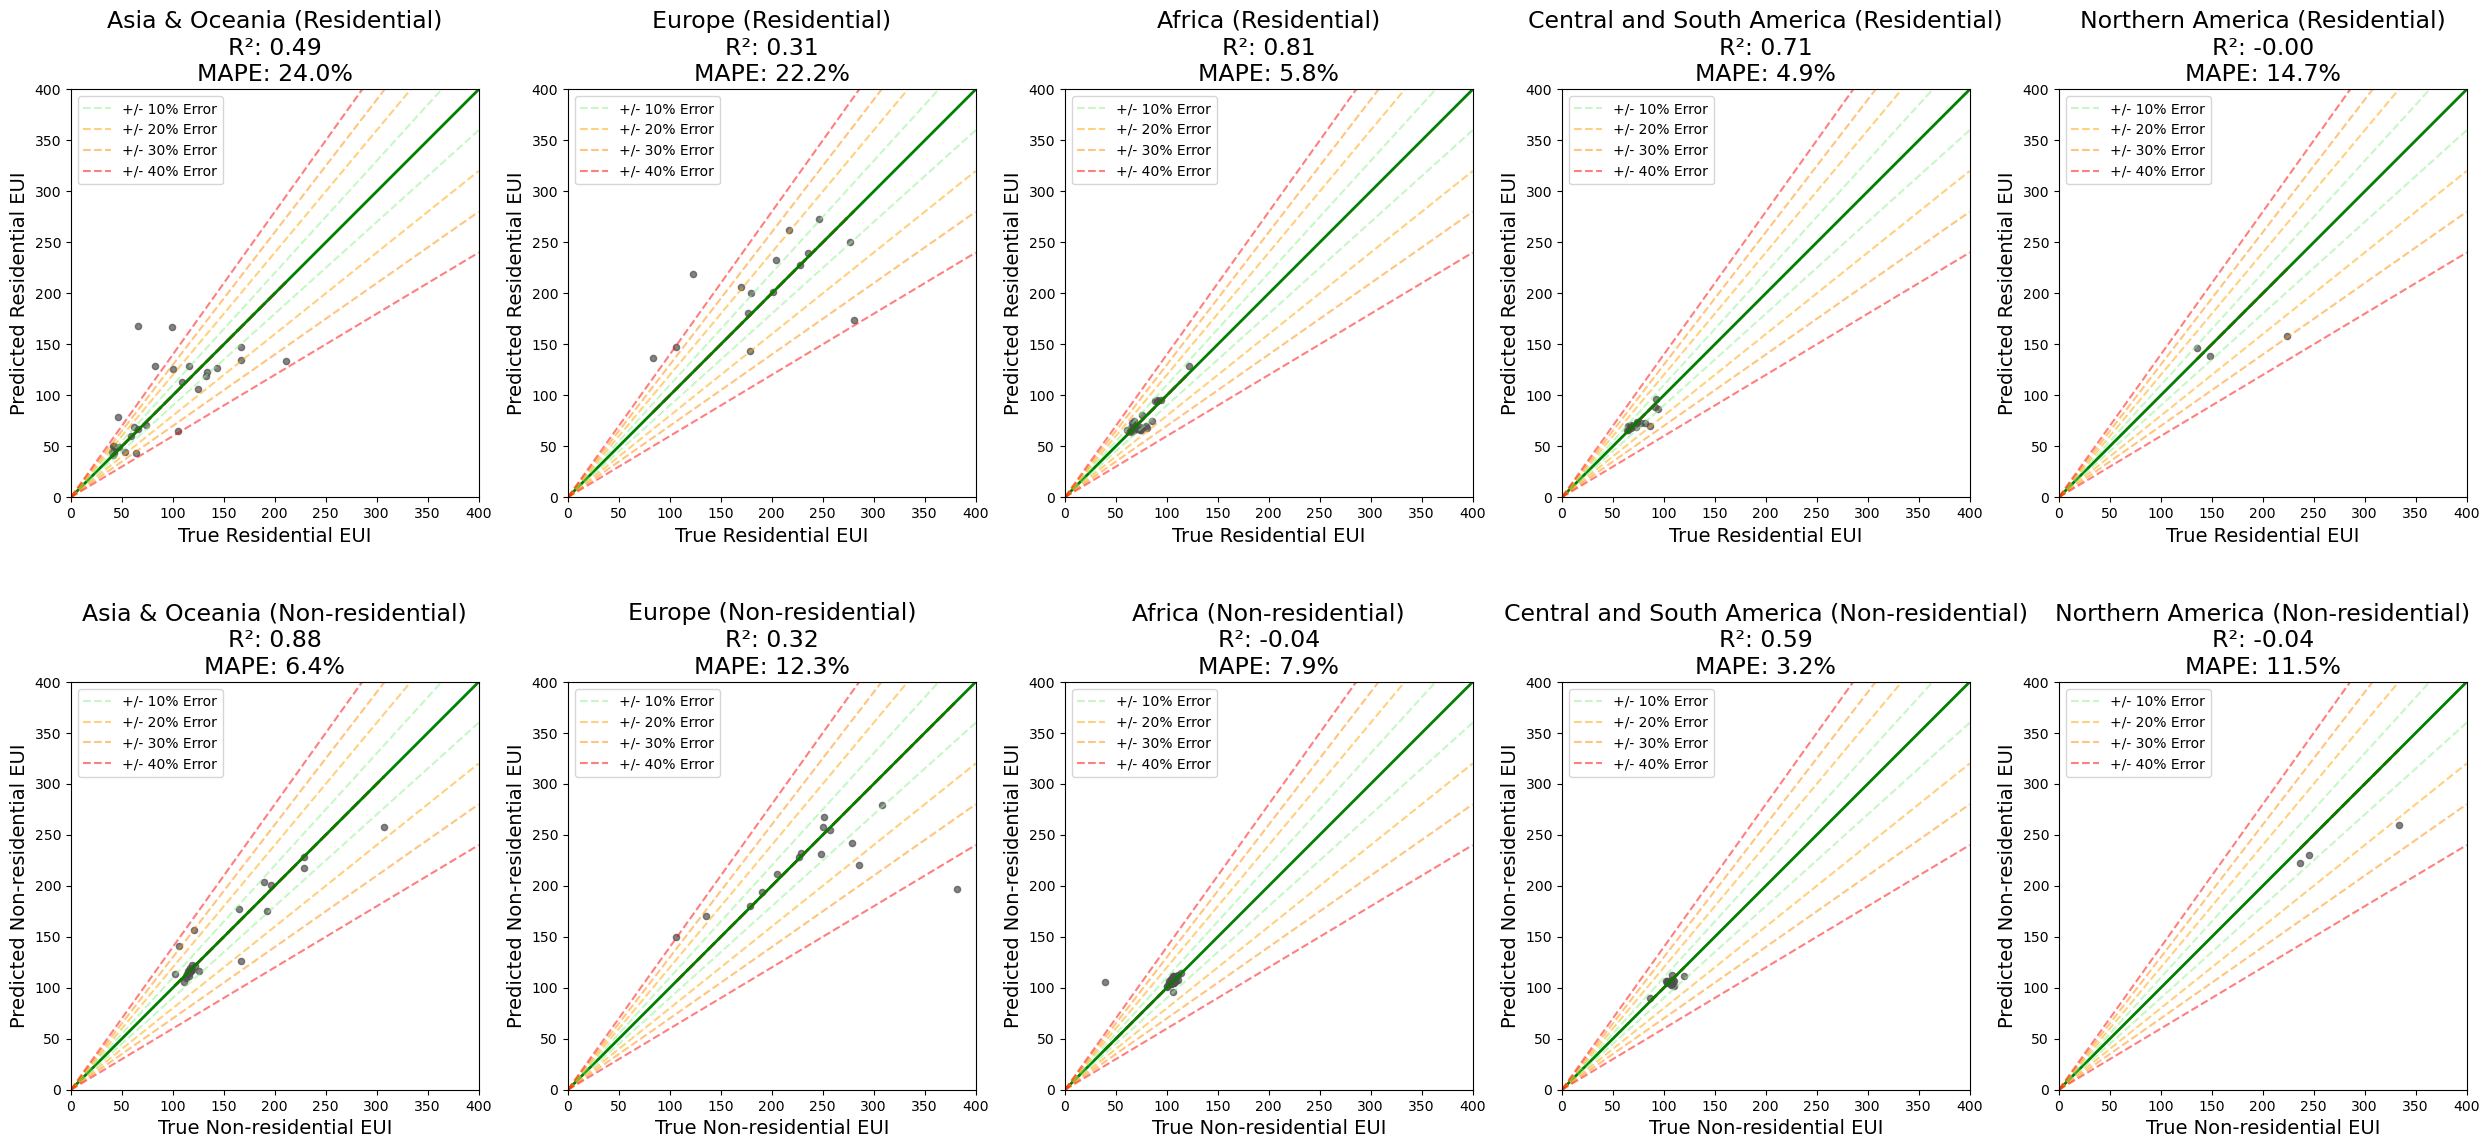

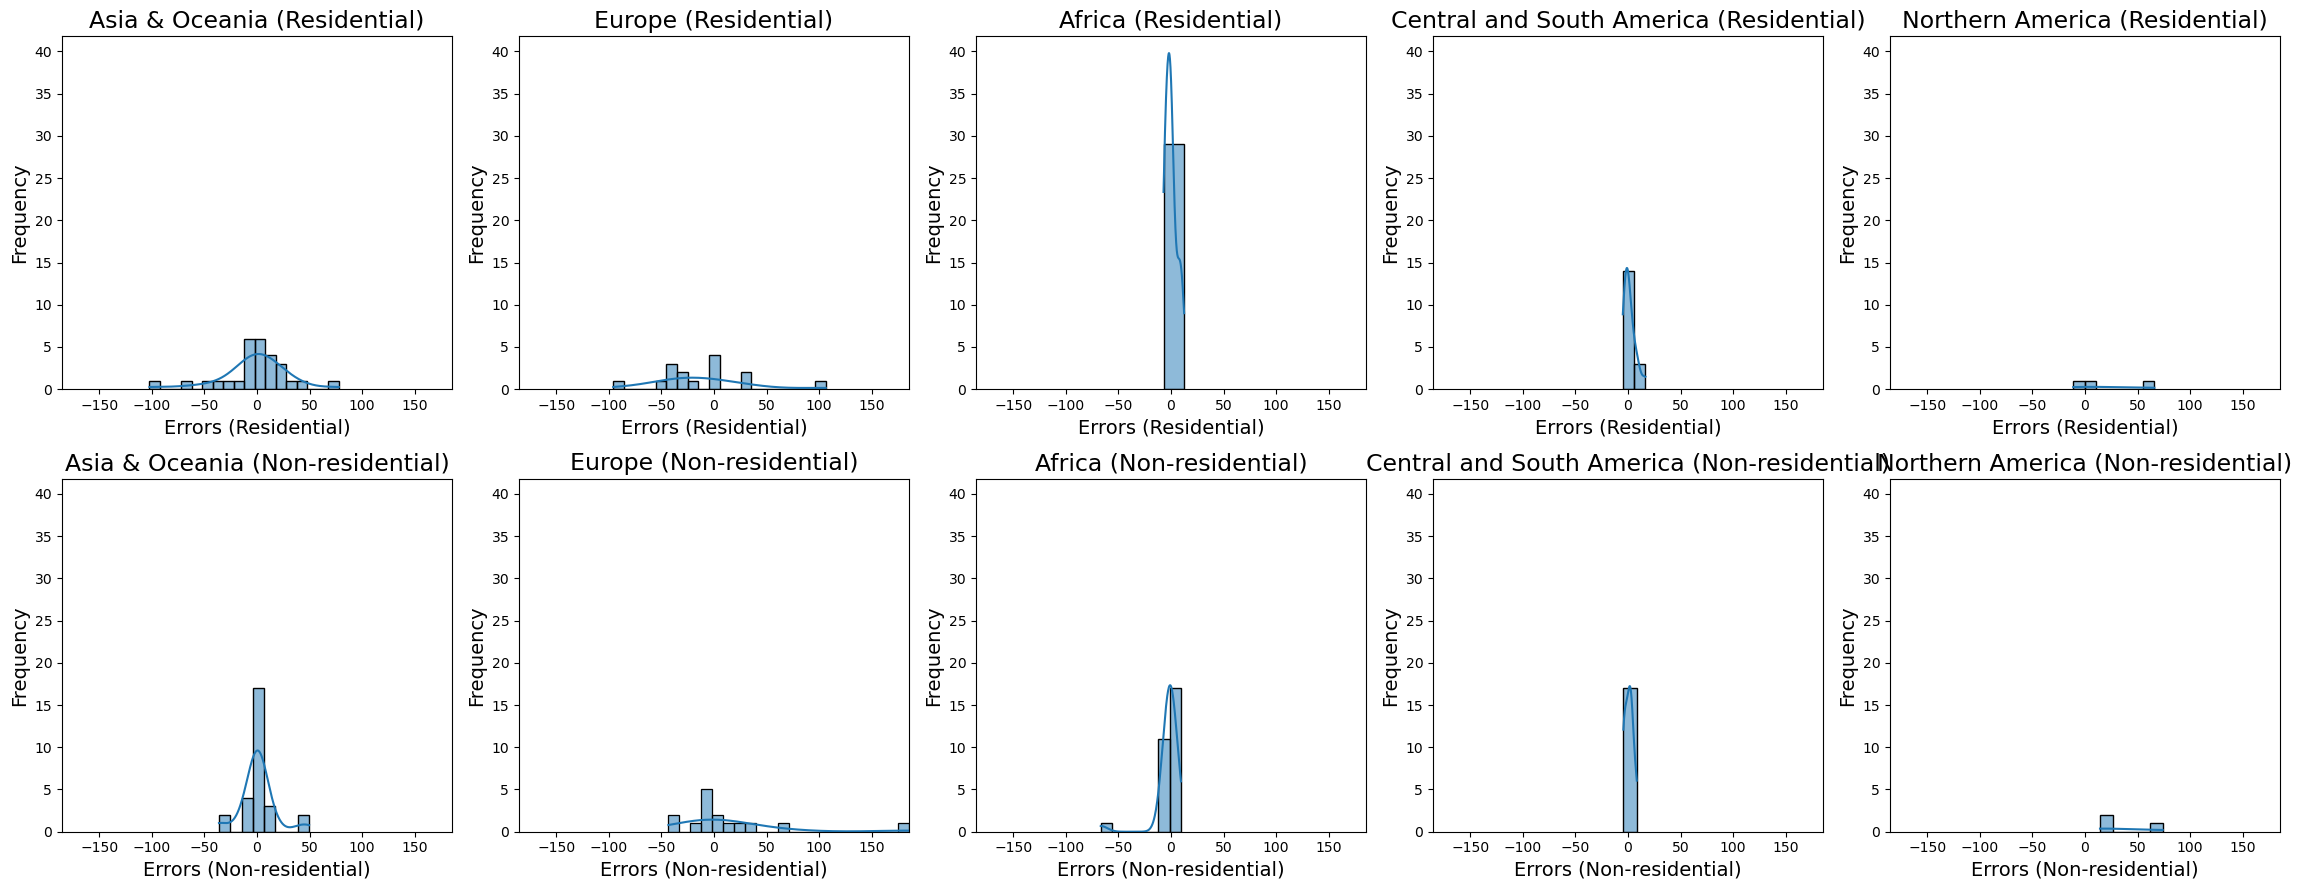

In [7]:
# Within-domain
model_rf_within = RandomForestRegressor(**rf_params)
results_rf_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_rf_within,
    strategy='within_domain'
)

create_eui_comparison_plots(results_rf_within, 
    save_path='../figures/model_plots/rf_within_domain_eui_predictions.png')

create_error_distribution_plots(results_rf_within,
    save_path='../figures/model_plots/rf_within_domain_error_distribution.png')

### Random Forest - Cross Domain

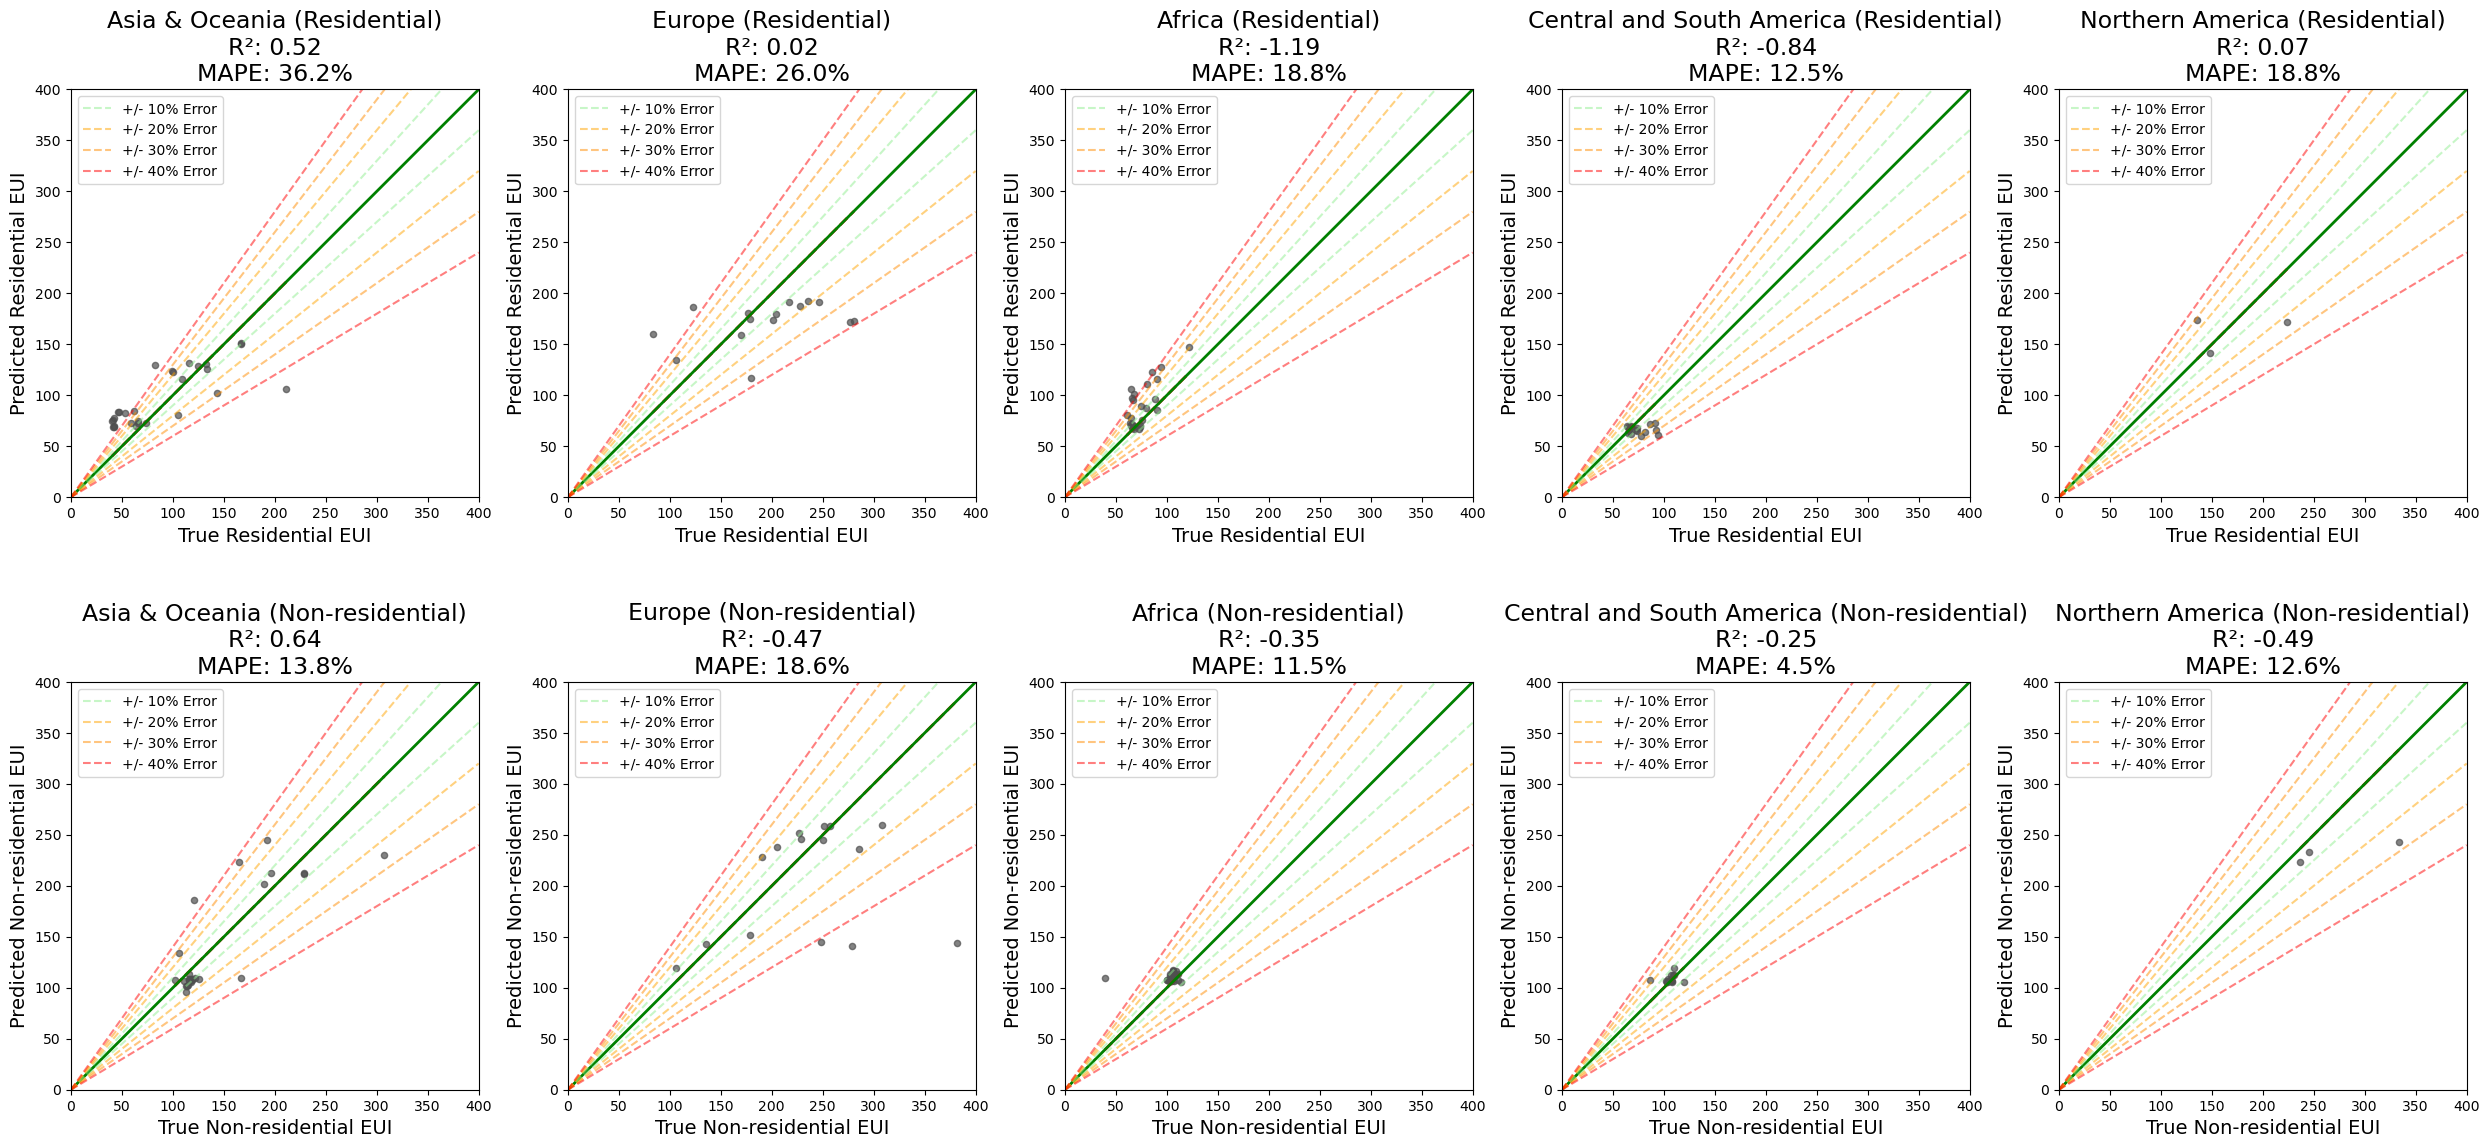

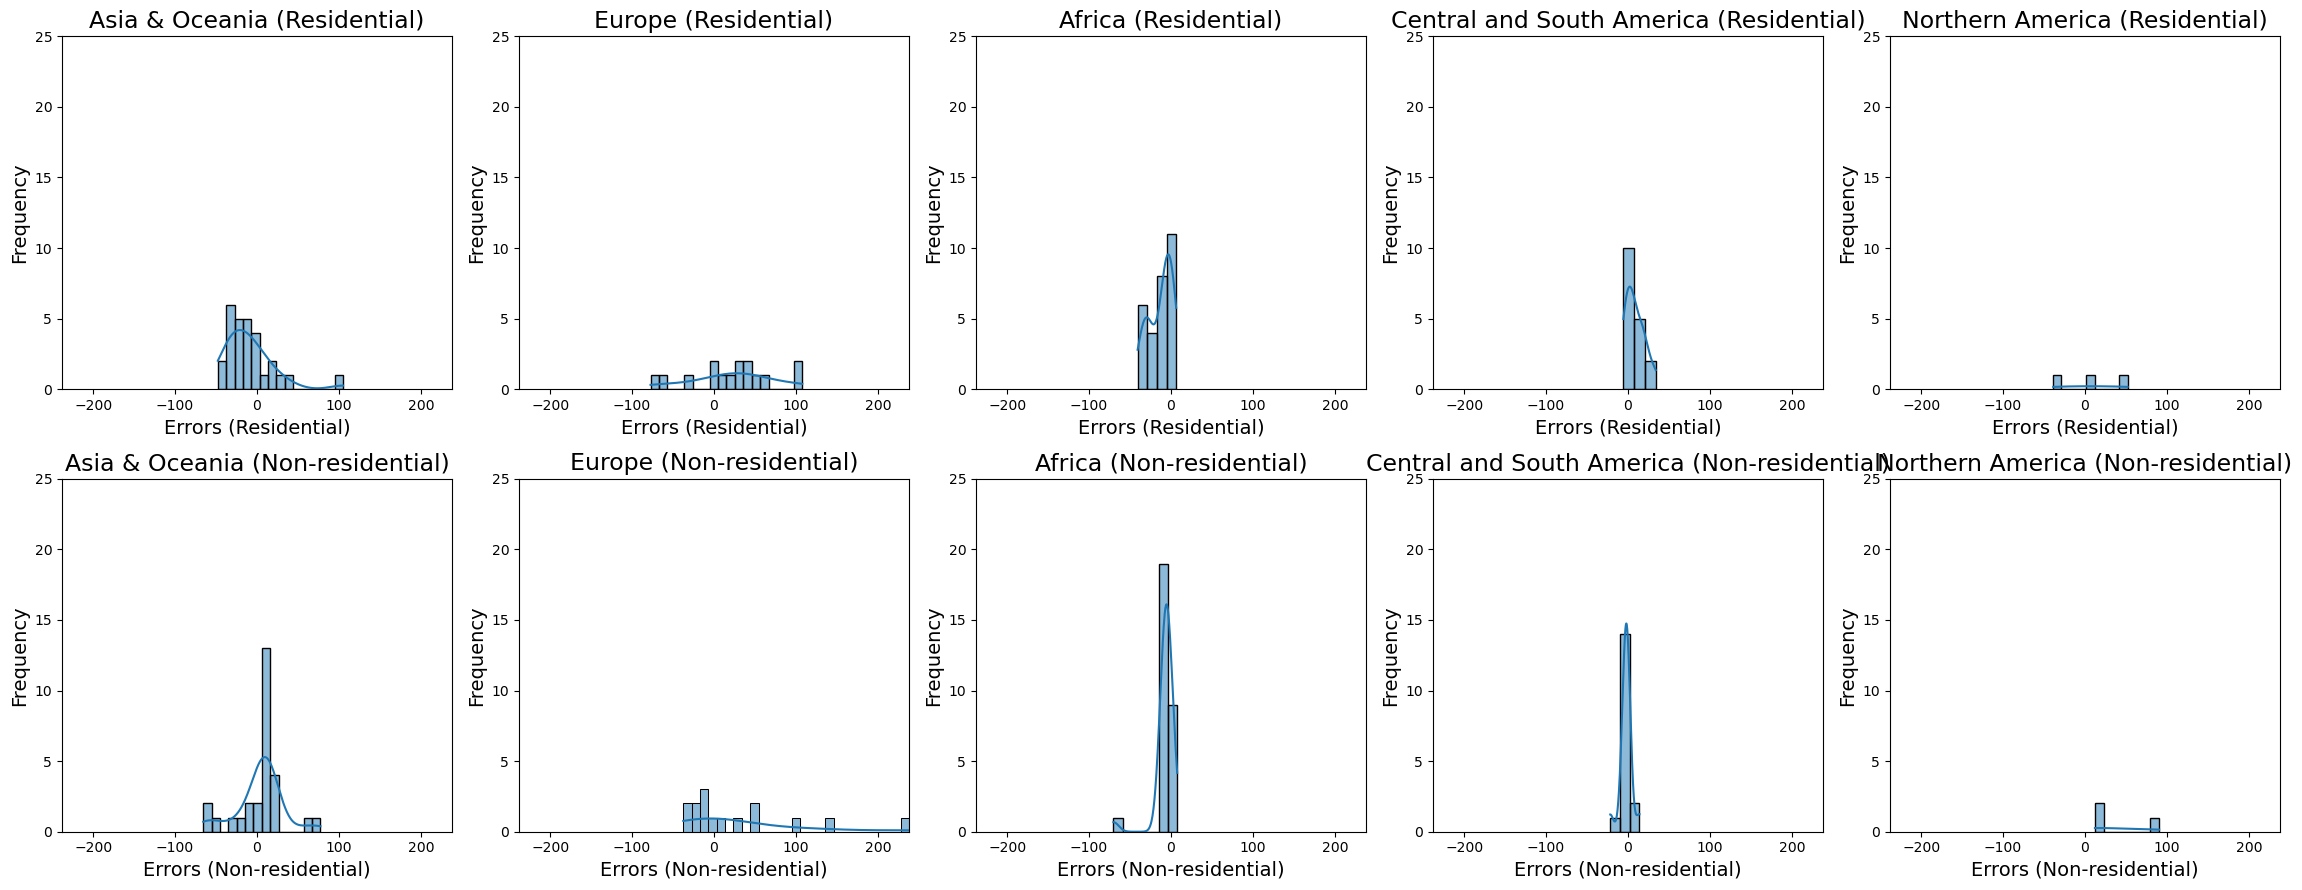

In [8]:
# Cross-domain
model_rf_cross = RandomForestRegressor(**rf_params)
results_rf_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_rf_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(results_rf_cross,
    save_path='../figures/model_plots/rf_cross_domain_eui_predictions.png')

create_error_distribution_plots(results_rf_cross,
    save_path='../figures/model_plots/rf_cross_domain_error_distribution.png')

### Random Forest - All Domain

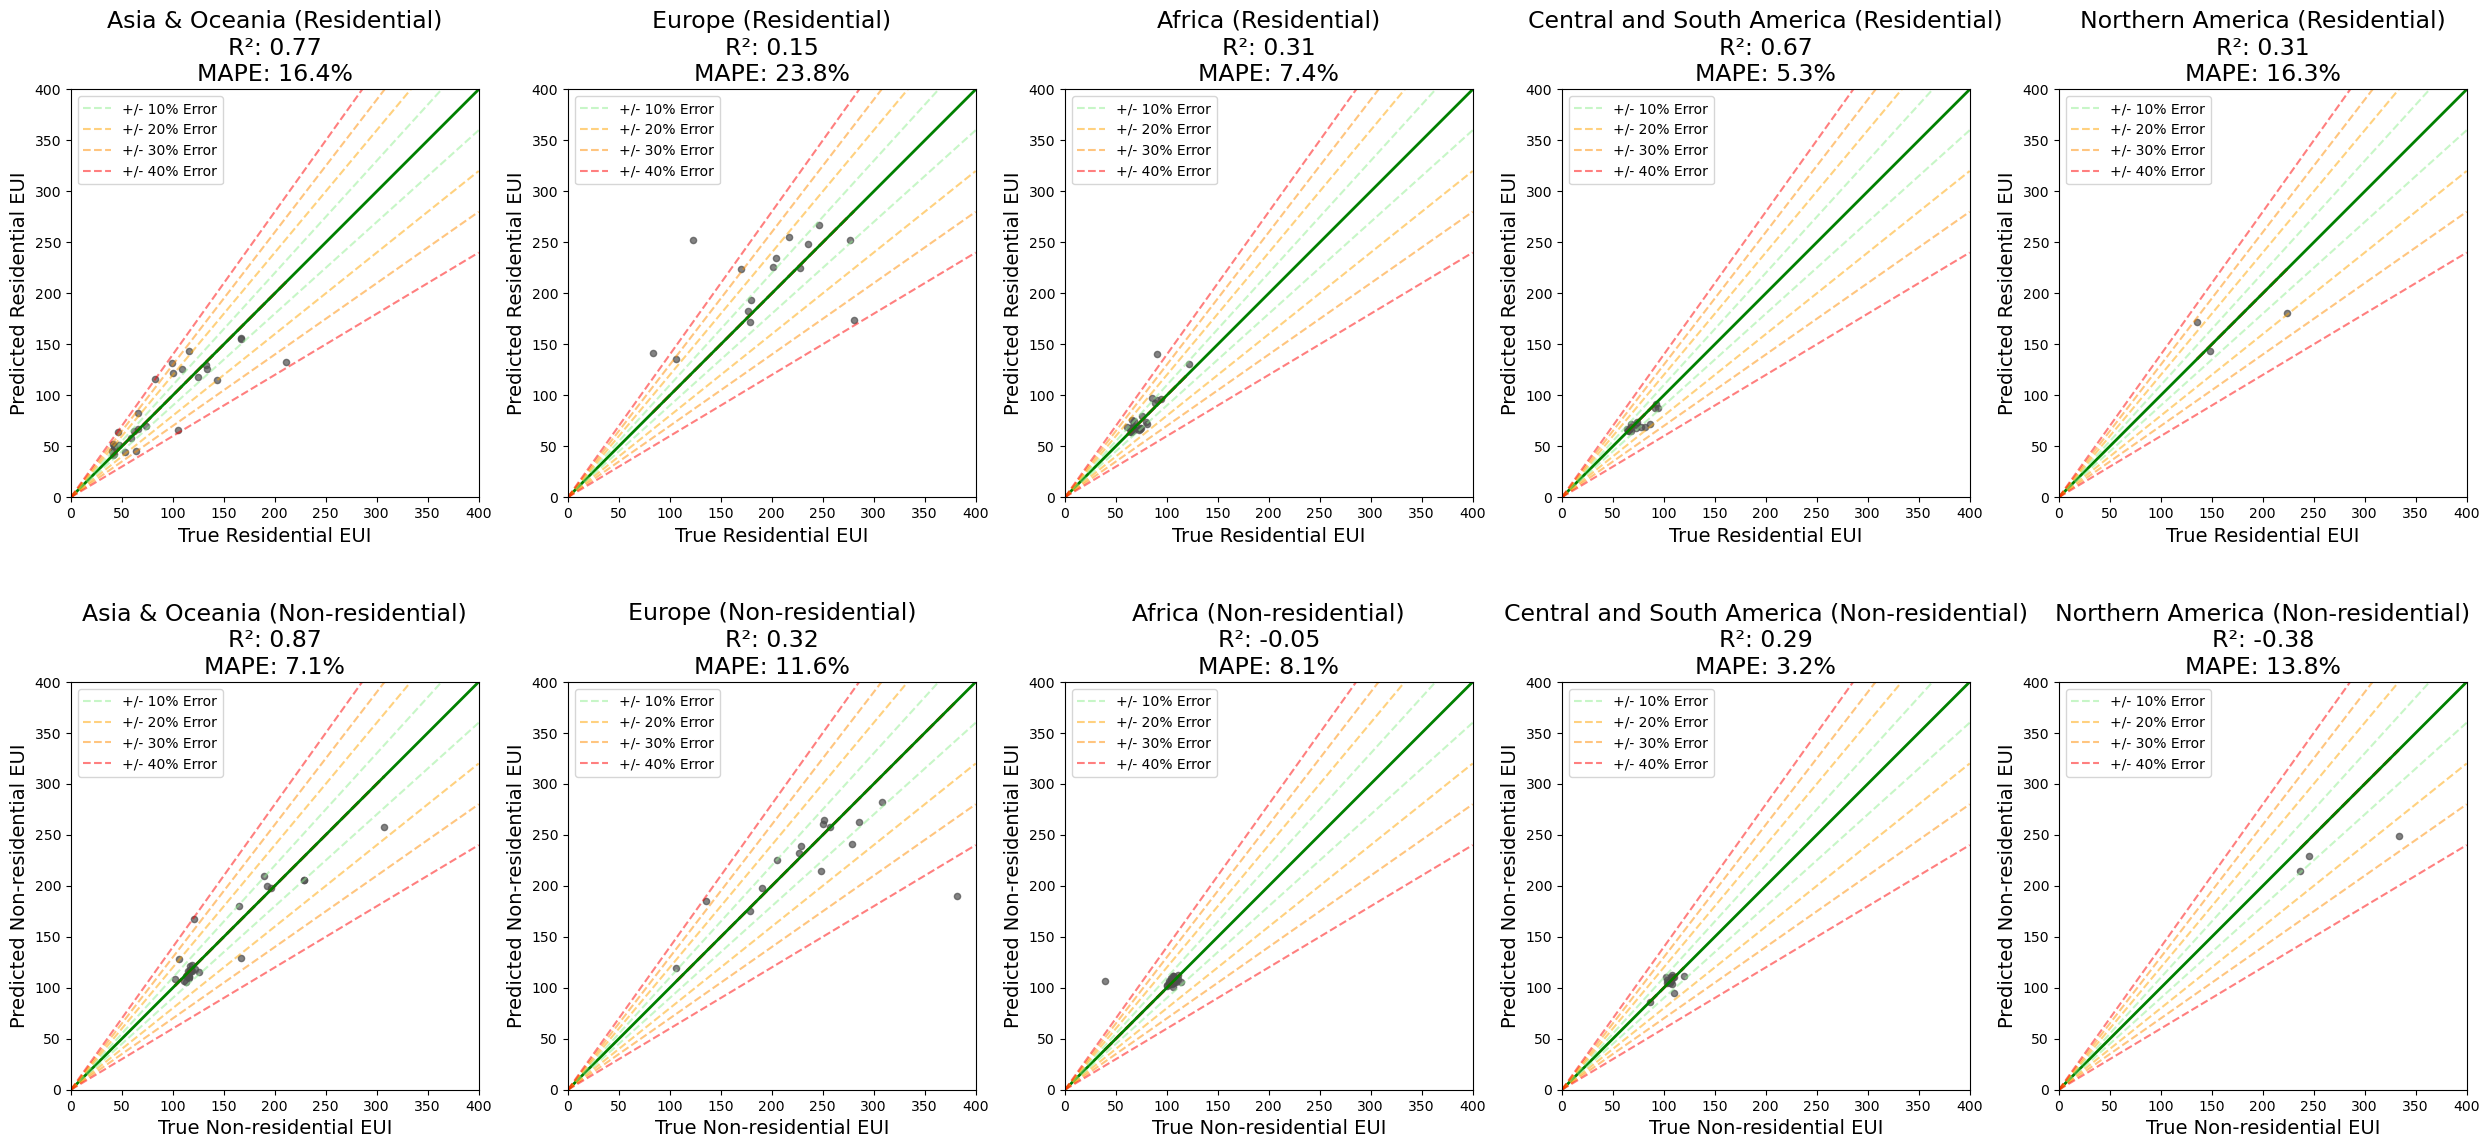

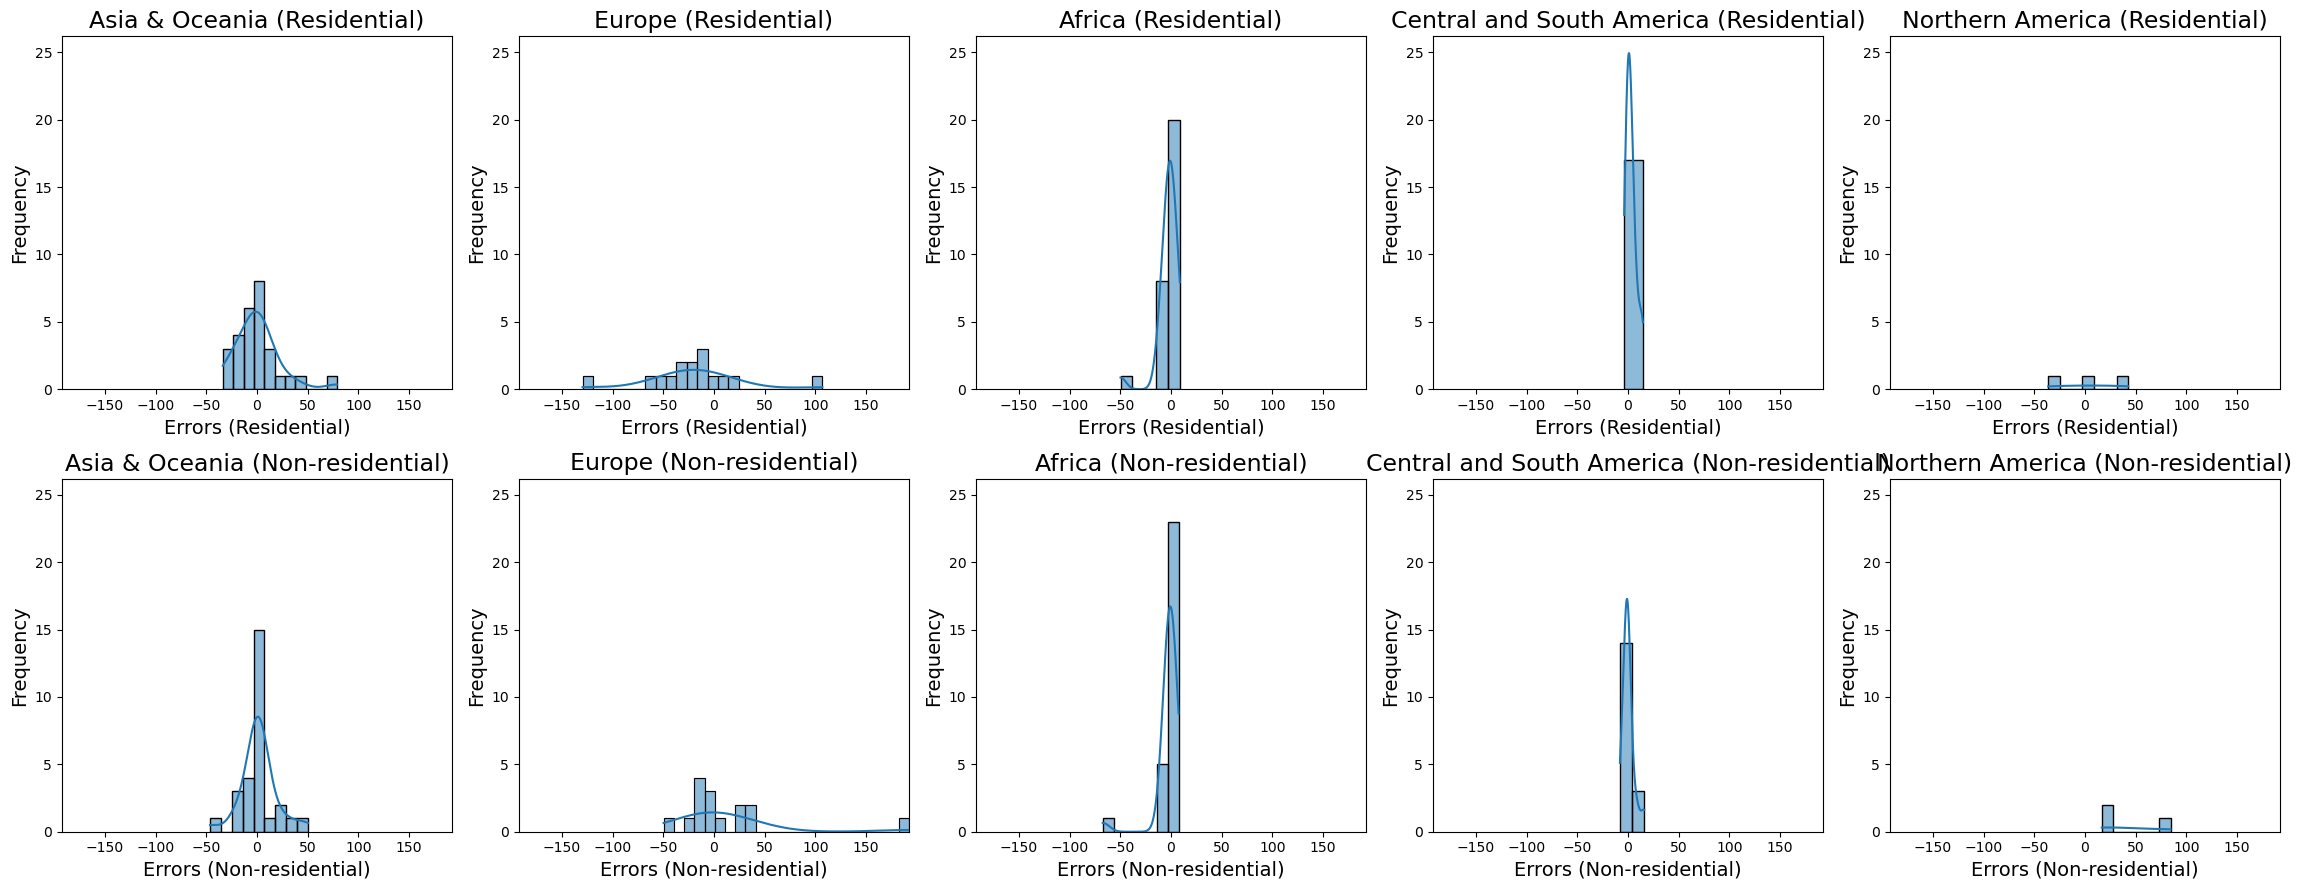

In [9]:
# All-domain
model_rf_all = RandomForestRegressor(**rf_params)
results_rf_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_rf_all,
    strategy='all_domain'
)

create_eui_comparison_plots(results_rf_all,
    save_path='../figures/model_plots/rf_all_domain_eui_predictions.png')

create_error_distribution_plots(results_rf_all,
    save_path='../figures/model_plots/rf_all_domain_error_distribution.png')

In [10]:
RFModel = lambda: RandomForestRegressor(**rf_params)
rf_detailed_results = evaluate_model_strategies(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_type=RFModel,  
    feature_abbreviations=feature_abbreviations,
    model_details=", ".join(f"{k}={v}" for k, v in rf_params.items())
)
rf_detailed_results['Model'] = 'RandomForestRegressor'

rf_average_results = calculate_average_metrics(rf_detailed_results).reset_index()
rf_average_results

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,RandomForestRegressor,n_estimators=100,"hdd_total_year, Subnational HDI, Income index,...",HDD | HDI | Income | Temp | Dew | Long_Cos | L...,8.78,0.252,1269.050,28.409,18.112,8.60
1,Non-residential EUI (kWh/m2/year),cross_domain,RandomForestRegressor,n_estimators=100,"hdd_total_year, Subnational HDI, Income index,...",HDD | HDI | Income | Temp | Dew | Long_Cos | L...,12.58,-0.191,2124.498,37.031,25.391,12.80
2,Non-residential EUI (kWh/m2/year),all_domain,RandomForestRegressor,n_estimators=100,"hdd_total_year, Subnational HDI, Income index,...",HDD | HDI | Income | Temp | Dew | Long_Cos | L...,8.60,0.252,1166.342,27.947,17.490,8.48
3,Residential EUI (kWh/m2/year),within_domain,RandomForestRegressor,n_estimators=100,"hdd_total_year, Subnational HDI, Income index,...",HDD | HDI | Income | Temp | Dew | Long_Cos | L...,14.36,0.449,1031.061,26.436,19.139,14.12
4,Residential EUI (kWh/m2/year),cross_domain,RandomForestRegressor,n_estimators=100,"hdd_total_year, Subnational HDI, Income index,...",HDD | HDI | Income | Temp | Dew | Long_Cos | L...,22.80,-0.516,1166.941,31.761,24.940,20.86
5,Residential EUI (kWh/m2/year),all_domain,RandomForestRegressor,n_estimators=100,"hdd_total_year, Subnational HDI, Income index,...",HDD | HDI | Income | Temp | Dew | Long_Cos | L...,13.80,0.442,854.887,24.541,17.884,13.28


In [11]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
rf_detailed_results.to_csv(f'../results/{timestamp}_rf_detailed_results.csv')
rf_average_results.to_csv(f'../results/{timestamp}_rf_average_results.csv')

# 